In [1]:
name = '2015-11-15-dissecting-patricia'
title = 'Dissecting Hurricane Patricia'
tags = 'python, dataviz, meteorology'

In [2]:
from nb_tools import connect_notebook_to_post
from IPython.core.display import HTML

html = connect_notebook_to_post(name, title, tags)

Last month an extremely powerful tropical cyclone was observed in the Eastern Pacific. The hurricane, titled Patricia, made history by breaking several records. Its estimated minimum central pressure of 880 hPa was the lowest ever recorded in the Western Hemisphere. NOAA's [Hurricane Hunters](http://flightscience.noaa.gov/) who collected precious measurements in the eye of the storm, revealed the storm to have acquired record maximum sustained winds of 200 mph (89.4 m/s).

It was also one of the most rapidly intensifying tropical cyclones with minimum central pressure falling by ~100 hPa in just 24 hours. Patricia's lifecycle from tropical depression to Category 5 hurricane to landfall and dissipation lasted from 20 to 24 October.

The media across the world were flooded with [stunning satellite imagery](http://www.weather.com/storms/hurricane/news/stunning-meteorological-images-hurricane-patricia) both in infrared and visible wave bands; [on-line wind field animations could not handle Patricia's intensity](https://pbs.twimg.com/media/CR_8qB-UYAAdyG8.png:large) and Hurricane Hunters released the [video](https://youtu.be/-G2ZdrYOwZM) of their historic flight.

So overall the hurricane was probed well both by remote instruments and *in-situ* measurements. However, I didn't see anywhere figures from another powerful meteorological observing tool - [NASA CloudSat mission](http://cloudsat.atmos.colostate.edu/).

Recently I used CloudSat data to investigate a polar low cloud structure. Having some code available, I decided to have a look at Patricia too. After waiting for about 12 days for the data being made available I checked if there were any overpasses close to Patricia when it reached maximum intensity. Luckily, the satellite flew over the western coast of Mexico on 23 October at around 20:35 - just before the landfall. It was a bit too late though too capture the crescendo of the storm life cycle.

Anyway, in this notebook I use Python to dissect Patricia's cloud field and plot a couple of figures.

### Tools
* Python 2.7.10
* cartopy 0.13.0
* h5py 2.5.0
* matplotlib 1.4.3
* numpy 1.10.1
* urllib 1.17

In [3]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

### Enough chit-chat, restrain the specimen!

In [4]:
from IPython.display import YouTubeVideo
import datetime
start=int(datetime.timedelta(hours=0, minutes=0, seconds=11).total_seconds())
YouTubeVideo('oHoeXFbc1PA', start=start, autoplay=0)

Obligatory, import all the necessary modules, starting with `matplotlib` magic.

In [5]:
%matplotlib inline

In [6]:
from __future__ import print_function, division
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import glob
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib
import subprocess

Next, I use some extra functions to read CloudSat data and load a colormap that is good to visualise radar reflectivity. Those functions are stored in `ccsat_tools.py` script that resides in one of my GitHub repositories: [satellite-data-analysis](https://github.com/dennissergeev/satellite-data-analysis).

In [7]:
import sys
sys.path.insert(0, '../../../satellite-data-analysis')
import ccsat_tools as ccsat

Here the approximate Earth radius is defined, I'll use it later.

In [8]:
r_earth = 6.371e3 # km

#### Input files

Before working with the CloudSat data, I have a look at cloud field photographed by another satellite instrument - MODIS on board Aqua satellite. I use Level-1B calibrated radiances at 1 km resolution. Below are the ftp links to the dataset as well as the corresponding geolocation data.

In [9]:
modis_l1b_url = 'ftp://ladsweb.nascom.nasa.gov/allData/6/MYD021KM/2015/296/MYD021KM.A2015296.2035.006.2015300182044.hdf'
modis_geo_url = 'ftp://ladsweb.nascom.nasa.gov/allData/6/MYD03/2015/296/MYD03.A2015296.2035.006.2015300180711.hdf'

I can retrieve the files simply by using `urllib` Python library.

In [10]:
if not os.path.exists(os.path.basename(modis_l1b_url)):
    urllib.urlretrieve(modis_l1b_url)
if not os.path.exists(os.path.basename(modis_geo_url)):
    urllib.urlretrieve(modis_geo_url)

The base names of the files are the following:

In [11]:
modis_l1b_fname = os.path.splitext(os.path.basename(modis_l1b_url))[0]+'.h5'
modis_geo_fname = os.path.splitext(os.path.basename(modis_geo_url))[0]+'.h5'

Note that I change the file extension to HDF-5, because I convert the original HDF-4 files using [`h4toh5` tool](https://www.hdfgroup.org/h4toh5/). It's not necessary, but I find h5py library more convenient to use.

In [12]:
if not os.path.exists(modis_l1b_fname):
    subprocess.call(['h4toh5', os.path.basename(modis_l1b_url)])
if not os.path.exists(modis_geo_fname):
    subprocess.call(['h4toh5', os.path.basename(modis_geo_url)])

Now it's time for CloudSat data. The file is also in HDF-5 format and since it's not heavy, I placed it in the `content/data` subfolder of this blog's GitHub repository.

In [13]:
cldst_fname = glob.glob('../data/*2B-GEOPROF*')[0] # Lazy way of getting the file name

The basic Level-2B data has all the geolocation data, which I read using `cloudsat_geodata` function in `ccsat_tools.py` script. The data includes radar beam longitudes, latitudes, height and time.

In [14]:
cldst_lons, cldst_lats, cldst_height, cldst_time, _ = ccsat.cloudsat_geodata(cldst_fname, return_list=True)

Data retrieval is done, and I can quickly make a map to see where CloudSat's radar dissected the hurricane.

#### Map of cloud field and satellite orbit path

##### Geolocation

To begin with, I open MODIS data to prepare the cloud image.

In [15]:
mod_data = h5py.File(modis_l1b_fname)
mod_geo = h5py.File(modis_geo_fname)

Then I get the longitudes and latitudes of MODIS data.

In [16]:
mlat = mod_geo['MODIS_Swath_Type_GEO']['Geolocation Fields']['Latitude'][:]
mlon = mod_geo['MODIS_Swath_Type_GEO']['Geolocation Fields']['Longitude'][:]

What is the time of the MODIS measurements? One way of getting it is to use the mean of one of the MODIS time arrays:

In [17]:
datetime.datetime(1993,1,1) + datetime.timedelta(seconds=np.mean(mod_geo['EV center time']))

datetime.datetime(2015, 10, 23, 20, 37, 39, 732807)

But probably it is easier to do by parsing the file name, since it contains the time stamp.

In [18]:
modis_date = os.path.basename(mod_geo.filename).split('.')[1]
modis_year = int(modis_date[1:5])
modis_day = int(modis_date[-3:])
modis_time = datetime.datetime.strptime(
             (datetime.datetime(modis_year, 1, 1) + datetime.timedelta(days=modis_day-1)).strftime('%Y%m%d')
              +os.path.basename(mod_geo.filename).split('.')[2],
              '%Y%m%d%H%M')

##### Emissivity data

I'm going to plot only one channel of MODIS data, namely the cloud emissivity in thermal infra-red (10.780-11.280 µm) part of spectrum.

In [19]:
ch31_ind = 10 # index of channel 31 within the dataset

In [20]:
ch_group = mod_data['MODIS_SWATH_Type_L1B/Data Fields/EV_1KM_Emissive']
ch31_data = ch_group.value[ch31_ind,:,:]

In [21]:
ch31_offset = ch_group.attrs['radiance_offsets'][ch31_ind]
ch31_scale = ch_group.attrs['radiance_scales'][ch31_ind]
ch31_data = (ch31_data - ch31_offset)*ch31_scale

In [22]:
map_title = 'MODIS Channel 31 radiance data ({})\n{}\nCloudSat orbit path (red)'.format(
             ch_group.attrs['radiance_units'],
             modis_time.strftime('%Y-%b-%d %H:%M'),
             )

In [23]:
mod_geo.close()
mod_data.close()

I'm not going to convert the radiance data to the brightness temperature of cloud tops, so now I'm ready to put the image on a map. I use `cartopy` module and a useful function `make_map` from [python4oceanographers blog](http://ocefpaf.github.io/python4oceanographers/)

##### Plotting

In [24]:
def make_map(projection=ccrs.PlateCarree(), resolution='110m'):
    fig, ax = plt.subplots(figsize=(15,8),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.coastlines(resolution)
    return fig, ax

It is convenient to define two rectangles: map limits and rough boundaries of the hurricane cloud field.

In [25]:
mapbox = (-120, -95, 12, 30)
bbox = (-110, -100, 15, 21)

Using the second box, I find the indices of CloudSat data that correspond to longitudes and latitudes within the box.

In [26]:
ii = np.where((cldst_lons>bbox[0]) & (cldst_lons<bbox[1]) &
              (cldst_lats>bbox[2]) & (cldst_lats<bbox[3]))[0]
i1, i2 = ii[0], ii[-1]

Voila:

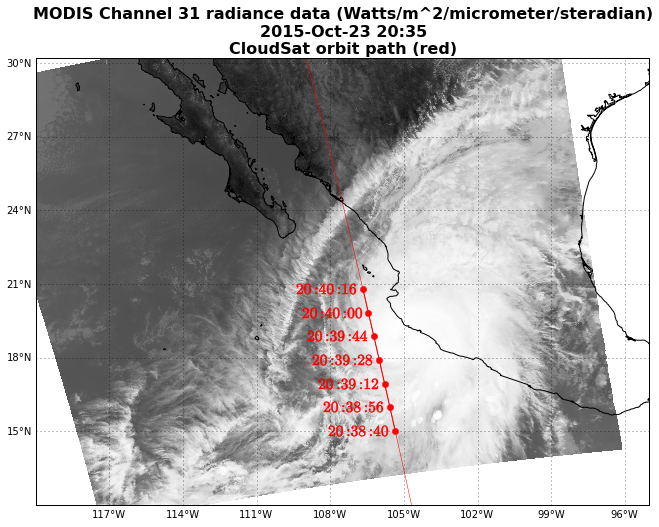

In [27]:
fig, ax = make_map(resolution='10m') # using higher resolution
ax.set_extent(mapbox)

im = ax.pcolormesh(mlon[:], mlat[:], ch31_data, cmap=plt.cm.gray_r)
ax.set_title(map_title, fontsize=16, fontweight='bold')

llstep=100 # stride lon-lat array
x, y = cldst_lons[i1:i2:llstep], cldst_lats[i1:i2:llstep]
_ = ax.plot(cldst_lons, cldst_lats, color='r', linewidth=0.5)
x_lab, y_lab = cldst_lons[i1:i2:llstep]-1.5, cldst_lats[i1:i2:llstep]
p = ax.plot(x, y, color='r', linestyle='-', marker='o', mec='r', mfc='r', zorder=100)
_ = [ax.plot(i, j, 
             marker=r"${}$".format(it.strftime('%H:%M:%S')),
             mec='r', mfc='r', ms=60, color='r', zorder=100) 
     for (i,j,it) in zip(x_lab,y_lab,cldst_time[i1:i2:llstep])]

The eye of the storm is barely distinguishable at $105^\circ W$, but it can be seen that CloudSat's orbit path goes 1-2 degrees to the west of the cyclone axis.

### CloudSat cloud reflectivity

I've been keeping the most interesting part for dessert. Now I'm going to plot a simple subset of CloudSat radar reflectivity data that is effectively a cross-section of cloud particles along the orbit path shown on the map above.

In [28]:
cldst_radar = ccsat.cloudsat_read_data(cldst_fname, data_field='Radar_Reflectivity')
cldst_radar = cldst_radar[i1:i2,:] # using the same i1 and i2 indices as on the map

It's necessary to mention that this part is based by the [`ccplot`](http://ccplot.org/) - an open-source CloudSat and CALIPSO plotting tool written in Python. The `ccplot` functions that are in my `ccsat_tools.py` script and are almost unchanged are:
* `cc_interp2d` (wrapped with `numba.jit()` instead of `cython` for fast interpolation)
* `get_cc_cmap` (to get the original `ccplot` colormaps for radar reflectivity)

#### Regridding

Even though the radar reflectivity is already on a regular distance-height grid, it needs regridding, because the actual height of vertical levels is not constant and looks like this:

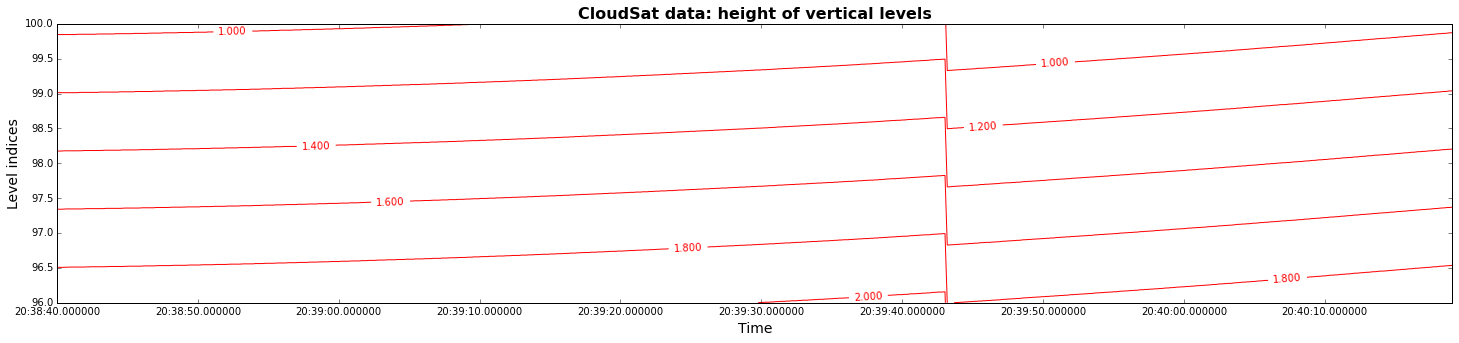

In [29]:
fig, ax = plt.subplots(figsize=(25,5))
c = ax.contour(cldst_time[i1:i2], np.arange(100,95,-1), cldst_height[i1:i2,100:95:-1].T*1e-3, colors='r')
cc = plt.clabel(c)
ax.set_title('CloudSat data: height of vertical levels', fontsize=16, fontweight='bold')
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Level indices', fontsize=14)

Therefore, I need to define a grid to regrid the original data.

In [30]:
cldst_X = np.arange(i1, i2, dtype=np.float32)
cldst_Z = (cldst_height*0.001).astype(np.float32)
cldst_h1 = 0  # km
cldst_h2 = 15  # km
cldst_nz = 500  # Number of pixels in the vertical.
cldst_z = np.linspace(cldst_h1,cldst_h2,cldst_nz)

Regridding is done by `ccsat.cc_interp2d` that uses `numba` for speed-up (if installed).

In [31]:
cldst_radar = ccsat.cc_interp2d(cldst_radar.filled(np.nan),
                                cldst_X, cldst_Z,
                                i1, i2, i2-i1, cldst_h2, cldst_h1, cldst_nz)
cldst_radar = cldst_radar.T[::-1,:]

#### Plotting CloudSat data

It is also necessary to convert datetime objects to numbers:

In [32]:
cldst_mdt = mpl.dates.date2num(cldst_time[i1:i2])

A useful function that I use below is defined next. It simply adds a horizontal axis below a given plot. 

In [33]:
def add_xaxis_below(parent_ax,xtick_array,xlab_array,shift_down):
    newax = parent_ax.twiny()
    newax.set_xticks(xtick_array)
    newax.set_xticklabels(xlab_array)
    newax.spines['left'].set_visible(False)
    newax.spines['right'].set_visible(False)
    newax.set_frame_on(True)
    newax.patch.set_visible(False)
    newax.xaxis.set_ticks_position('bottom')
    newax.xaxis.set_label_position('bottom')
    newax.spines['bottom'].set_position(('outward', shift_down))
    newax.tick_params(axis='both', which='major', labelsize=16)
    newax.grid('off')
    return newax

And I am now ready to draw the radar reflectivity in time-height axes.

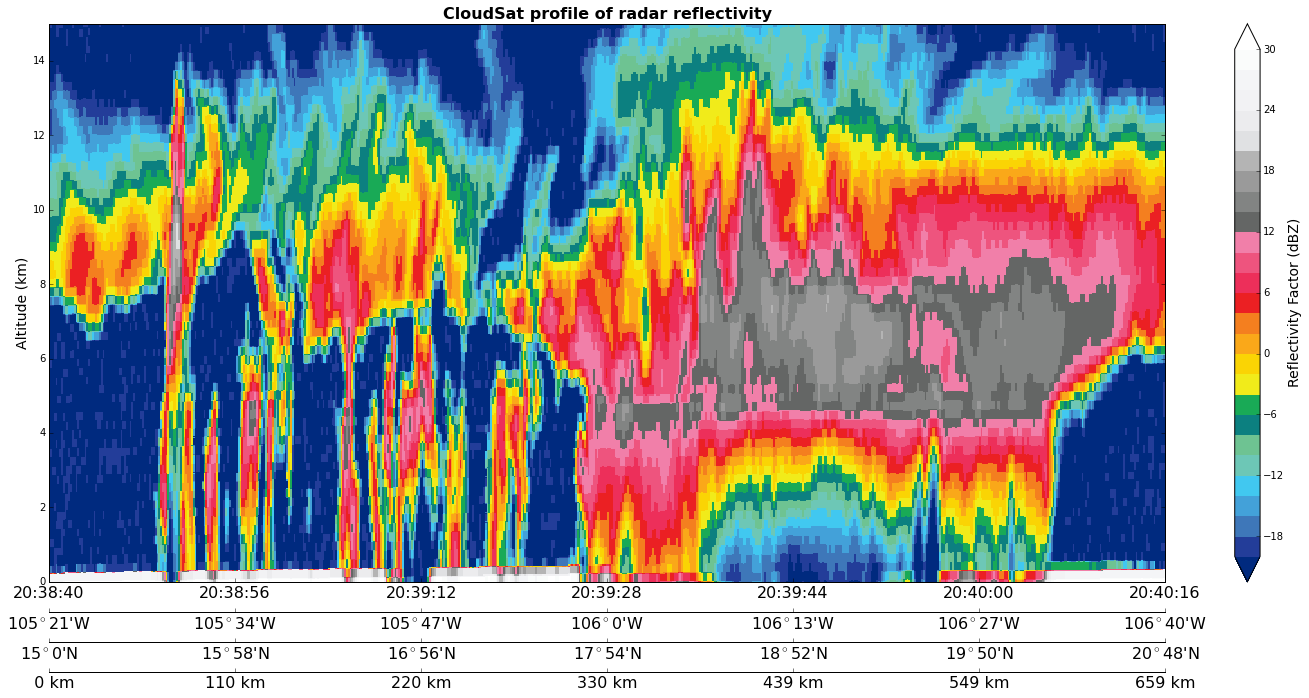

In [34]:
fig, ax = plt.subplots(figsize=(25, 10))

#
# Main plot
#
im = ax.pcolormesh(cldst_mdt, cldst_z, cldst_radar,
                   **ccsat.get_cc_cmap('cloudsat')) #

# Set axis limits to exclude white space
ax.set(xlim=[cldst_mdt[0], cldst_mdt[-1]], ylim=[cldst_h1, cldst_h2])

# Title and y-axis label
ax.set_title('CloudSat profile of radar reflectivity', fontsize=16, fontweight='bold')
ax.set_ylabel('Altitude (km)', fontsize=14)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, extend='both')
cbar.set_label('Reflectivity Factor (dBZ)', fontsize=14)


#
# X-axis tweaks
#
# Get rid of the original x-axis ticks and labels
ax.xaxis.set_visible(False)
ax.spines['bottom'].set_color('w')

# Subset longitude and latitude arrays
lon, lat = cldst_lons[i1:i2:llstep], cldst_lats[i1:i2:llstep]

# Define ticks and ticklabels of four additional x-axes
llticks = np.linspace(0,1,len(lon))
xlabels_t = [i.strftime('%H:%M:%S') for i in cldst_time[i1:i2:llstep]]
try:
    import LatLon as LL
    # Use fancy format for lon and lat labels
    xlabels_lat = [LL.Latitude(i).to_string("d%$^\circ$%m%'%H") for i in lat]
    xlabels_lon = [LL.Longitude(i).to_string("d%$^\circ$%m%'%H") for i in lon]
except ImportError:
    xlabels_lat = ['{}'.format(i) for i in lat]
    xlabels_lon = ['{}'.format(i) for i in lon]

# Add new axes
newax_t = add_xaxis_below(ax, llticks, xlabels_t, 0) # Time
newax_lon = add_xaxis_below(ax, llticks, xlabels_lon, 30) # Longitudes, with shift 30 down
newax_lat = add_xaxis_below(ax, llticks, xlabels_lat, 60) # Latitudes, with shift 60 down

# Add distance labels
# Note: calculated approximately from lon-lat arrays
dist = [0]
for i in xrange(1, len(lon)):
    dist.append(
                r_earth*np.arccos( \
                np.sin(np.radians(lat[i-1]))*np.sin(np.radians(lat[i])) + \
                np.cos(np.radians(lat[i-1])) \
                *np.cos(np.radians(lat[i]))*np.cos(np.radians(lon[i-1]-lon[i]))
                                           )
                )
# Add the new axis with distance labels
newax_dist = add_xaxis_below(ax, llticks,['{0:3.0f} km'.format(i) for i in np.cumsum(dist)], 90)

The figure shows multiple convective plumes in the southern (left) part of the cross-section, which occurred on the periphery of hurricane Patricia. Further to the north CloudSat's radar probed a vigorous band of clouds developing up to 16 km and manifesting themselves by radar reflectivity reaching ~20 dBZ at heights about 6 km.

It would be interesting to compliment this plot with other CloudSat products and CALIPSO backscatter data. Well, maybe in another post.

In [35]:
HTML(html)